In [1]:
import warnings
import os,sys
sys.path.append("./share")
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import warnings,logging,re
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from SHVisualize import CSHVisualize
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from SHModelClassify import CSHModelClassify
from SHEvaluation import CSHROC
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHFeatureSelect import CSHFeature
tqdm.pandas()
import h2o
h2o.init(nthreads = -1, verbose=False)

# 定义公共函数

In [8]:
def is_valid_ip(ip_str):
    ip_pattern = re.compile(r'^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    if ip_pattern.match(ip_str):
        octets = ip_str.split('.')
        for octet in octets:
            if int(octet) > 255:
                return False
        return True
    else:
        return False

def is_valid_time(time_str):
    tmp = time_str.strip()
    tmp = tmp[:-3]
    try:
        datetime.strptime(tmp, '%Y %H:%M:%S.%f')
        return True
    except ValueError:
        return False

In [9]:
df = pd.read_csv("./Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv",low_memory=False)

# 过滤掉异常数据
1. 时间格式错误
2. ip地址错误

In [10]:
def pre_process(x):
    ret = "ok"
    if not is_valid_time(x['frame.time']):
        ret = "frame.time"
    elif not is_valid_ip(x['ip.src_host']) and not is_valid_ip(x['arp.src.proto_ipv4']):
        ret = "src_host"
    elif not is_valid_ip(x['ip.dst_host']) and not is_valid_ip(x['arp.dst.proto_ipv4']):
        ret = "dst_host"
    return ret
    
df['flag'] = df.progress_apply(pre_process,axis=1)
df = df[df['flag'] == "ok"]

del df['frame.time']
del df['ip.src_host']
del df['ip.dst_host']
del df['arp.src.proto_ipv4']
del df['arp.dst.proto_ipv4']
del df['tcp.srcport']
del df['tcp.dstport']
del df['udp.port']
del df['tcp.payload']
del df['http.tls_port']
del df['http.file_data']
del df['icmp.transmit_timestamp']
del df['http.request.uri.query']
del df['http.referer']
del df['http.request.full_uri']
del df['http.request.version']
del df['tcp.options']
del df['dns.qry.name.len']
del df['mqtt.msg']

one_hot_encoded = pd.get_dummies(df['http.request.method'],prefix='http.request.method')
df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.conack.flags'],prefix='mqtt.conack.flags')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.protoname'],prefix='mqtt.protoname')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.topic'],prefix='mqtt.topic')
#df = pd.concat([df, one_hot_encoded], axis=1)

#del df['http.request.method']
del df['mqtt.conack.flags']
del df['mqtt.protoname']
del df['mqtt.topic']
df['Attack_type']=df['Attack_type'].astype(dtype='category')
df['Attack_code']=df['Attack_type'].cat.codes

  0%|          | 0/157800 [00:00<?, ?it/s]

In [14]:
df['http.request.method'].value_counts()

http.request.method
0.0        75639
0          53709
GET         6676
POST         267
TRACE        252
OPTIONS        1
Name: count, dtype: int64

In [12]:
one_hot_encoded

,http.request.method_0,http.request.method_0.0,http.request.method_GET,http.request.method_OPTIONS,http.request.method_POST,http.request.method_TRACE
1214,False,True,False,False,False,False
1215,False,True,False,False,False,False
1216,False,True,False,False,False,False
1217,False,True,False,False,False,False
1218,False,True,False,False,False,False
...,...,...,...,...,...,...
157795,False,True,False,False,False,False
157796,False,True,False,False,False,False
157797,False,True,False,False,False,False
157798,False,True,False,False,False,False


# 发现异常特征
1. mqtt.conack.flags
2. mqtt.protoname
3. mqtt.topic

In [104]:
#mqtt.conack.flags_0',
#'mqtt.conack.flags_0.0',
#'mqtt.conack.flags_0x00000000'
#df_tmp = df[['http.request.method','mqtt.protoname','mqtt.topic','mqtt.conack.flags','Attack_label']]
#df_tmp=df_tmp[df_tmp['Attack_label'] == 1]
#df_tmp.nunique()

# 选取base的特征
1. 去掉冗余字段
2. 设置特征字段和标签字段
3. 去掉只有唯一值的特征

In [105]:
df_base = df.copy(deep=True)
del df_base['Attack_type']
del df_base['flag']
del df_base['Attack_code']

#for col in df_base.columns.tolist():
#    if col in ['tcp.ack','tcp.flags','tcp.connection.rst','http.request.method_0.0','tcp.ack_raw','http.request.method_0']:
#        del df_base[col]
        
for key in df_base.columns:
    if df_base[key].nunique() <= 1:
        del df_base[key]

col_y = "Attack_label"
col_x = []
for col in df_base.columns.tolist():
    if not col == col_y:
        col_x.append(col)

# 进行SMOTE采样

In [106]:
df_tmp = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 

# 对特征字段进行标准化处理

In [107]:
df_data, scale_columns = CSHDataProcess.get_scale(df_tmp,y_column=col_y)

# 查看信息图

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%


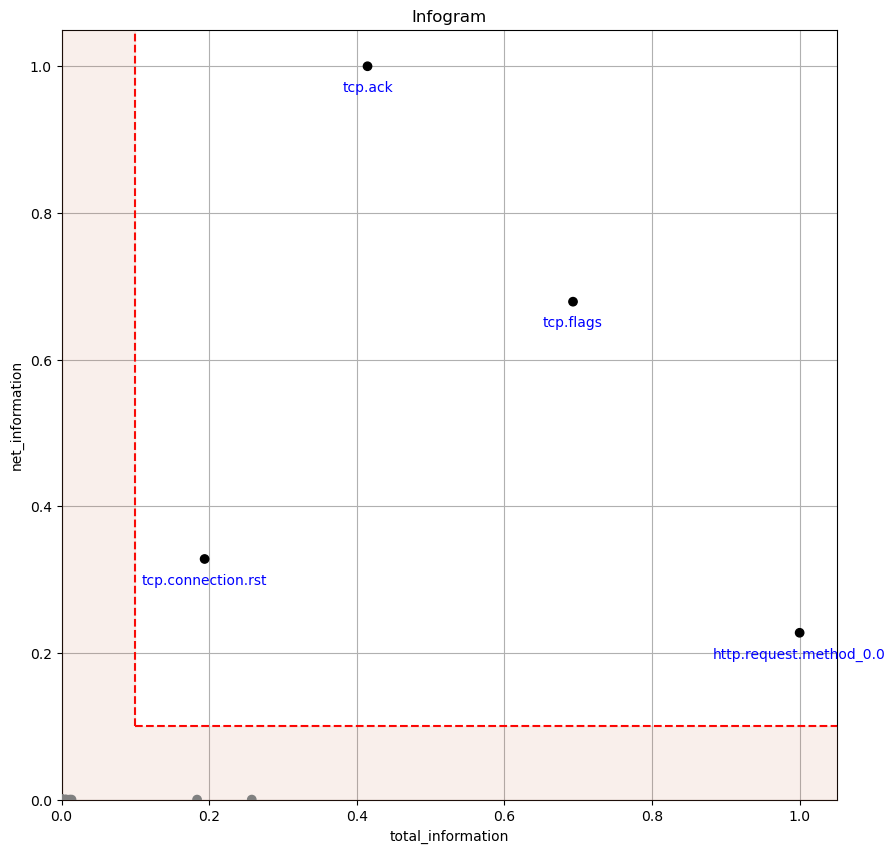

In [108]:
Fea = CSHFeature()
Fea.load(df_data,x_columns = col_x, y_column=col_y,is_regression = False)
ig = Fea.get_inform_graph("AUTO")
ig.plot()

CSHDataDistribution.show_dist(df_data['tcp.ack'])
CSHDataDistribution.normal_test(df_data['tcp.ack'])

# 划分为训练集和测试集

In [109]:
df_train,df_test = CSHSample.split_dataset(df_data)

# 训练模型和特征重要程度

In [110]:
model = CSHModelClassify()
model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
model.importance()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
begin train  dt
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
end train  dt
begin train  svm
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
end train  svm
begin train  rf
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
end train  rf
begin train  ann
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
end train  ann
begin train  knn
train knn
end train  knn


,variable,relative_importance,scaled_importance,percentage,model
0,http.request.method_0.0,291320.68750000,1.00000000,0.18485251,rf
1,tcp.flags,228115.95312500,0.78304069,0.14474704,rf
2,http.request.method_0,194385.50000000,0.66725608,0.12334396,rf
3,mqtt.msgtype,154977.98437500,0.53198414,0.09833860,rf
4,tcp.ack,127424.87500000,0.43740414,0.08085525,rf
...,...,...,...,...,...
81,http.request.method_0.0.missing(NA),0.00000000,0.00000000,0.00000000,ann
82,http.request.method_GET.missing(NA),0.00000000,0.00000000,0.00000000,ann
83,http.request.method_OPTIONS.missing(NA),0.00000000,0.00000000,0.00000000,ann
84,http.request.method_POST.missing(NA),0.00000000,0.00000000,0.00000000,ann


# 评估模型

In [111]:
model.evaluate(df_test,x_columns=col_x,y_column=col_y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,model,confusion_matrix,recall,mcc,accuracy,precision,auc,f1_score,fbeta_score
0,ann,"[[22530, 770], [194, 23063]]",0.97929420,0.95888288,0.97929420,0.97958829,0.97930561,0.97929127,0.97943346
1,dt,"[[23239, 61], [5840, 17417]]",0.87325214,0.77058042,0.87325214,0.89774771,0.87313739,0.87125347,0.88342585
2,knn,"[[22947, 353], [332, 22925]]",0.98528685,0.97057410,0.98528685,0.98528726,0.98528726,0.98528686,0.98528705
3,rf,"[[23236, 64], [177, 23080]]",0.99482355,0.98965870,0.99482355,0.99483519,0.99482130,0.99482351,0.99482911
4,svm,"[[19348, 3952], [1707, 21550]]",0.87845007,0.76046571,0.87845007,0.88201332,0.87849450,0.87817223,0.87997627


# 将特征进行Normal转换

In [112]:
df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 

In [113]:
df_tmp = df_data.copy(deep = True)
scale_colums = []
for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
    if not type in ["bool","object","category"] and not key in [col_y]:
        scale_colums.append(key)

for key in scale_colums:
    df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
    df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    
df_train,df_test = CSHSample.split_dataset(df_tmp)

In [114]:
model = CSHModelClassify()
model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
model.importance()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
begin train  dt
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
end train  dt
begin train  svm
psvm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%
end train  svm
begin train  rf
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
end train  rf
begin train  ann
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
end train  ann
begin train  knn
train knn
end train  knn


,variable,relative_importance,scaled_importance,percentage,model
0,http.request.method_0.0,394549.78125000,1.00000000,0.24156195,rf
1,http.request.method_0,190691.18750000,0.48331338,0.11675012,rf
2,tcp.flags,175171.59375000,0.44397843,0.10724830,rf
3,tcp.ack,159703.50000000,0.40477402,0.09777800,rf
4,tcp.seq,159324.78125000,0.40381414,0.09754613,rf
...,...,...,...,...,...
81,http.request.method_0.0.missing(NA),0.00000000,0.00000000,0.00000000,ann
82,http.request.method_GET.missing(NA),0.00000000,0.00000000,0.00000000,ann
83,http.request.method_OPTIONS.missing(NA),0.00000000,0.00000000,0.00000000,ann
84,http.request.method_POST.missing(NA),0.00000000,0.00000000,0.00000000,ann


In [115]:
model.evaluate(df_test,x_columns=col_x,y_column=col_y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |█████████████████████████████████Job request failed Unexpected HTTP error: ('Connection aborted.', BadStatusLine('GET /3/Jobs/$03017f00000132d4ffffffff$_938e5d1adb8c825bc8be0867bff6450f HTTP/1.1\r\n')), will retry after 3s.
█████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,model,confusion_matrix,recall,mcc,accuracy,precision,auc,f1_score,fbeta_score
0,ann,"[[23237, 57], [326, 22937]]",0.99177352,0.98361259,0.99177352,0.99183914,0.99176967,0.99177322,0.99180482
1,dt,"[[23258, 36], [5788, 17475]]",0.87490603,0.77377253,0.87490603,0.89927136,0.87482371,0.87295622,0.88505406
2,knn,"[[22855, 439], [201, 23062]]",0.98625341,0.97255783,0.98625341,0.98630434,0.98625681,0.98625310,0.98627765
3,rf,"[[23237, 57], [208, 23055]]",0.99430805,0.98863685,0.99430805,0.99432883,0.99430589,0.99430798,0.99431798
4,svm,"[[18974, 4320], [6962, 16301]]",0.75767339,0.51866176,0.75767339,0.76101780,0.75763550,0.75688126,0.75876160


# 调试

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt prediction progress: |████████████████████████████████████████████████████████| (done) 100%
psvm prediction progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
1 ROC AUC OvR: 0.0399
0 ROC AUC OvR: 0.0395
average ROC AUC OvR: 0.0397


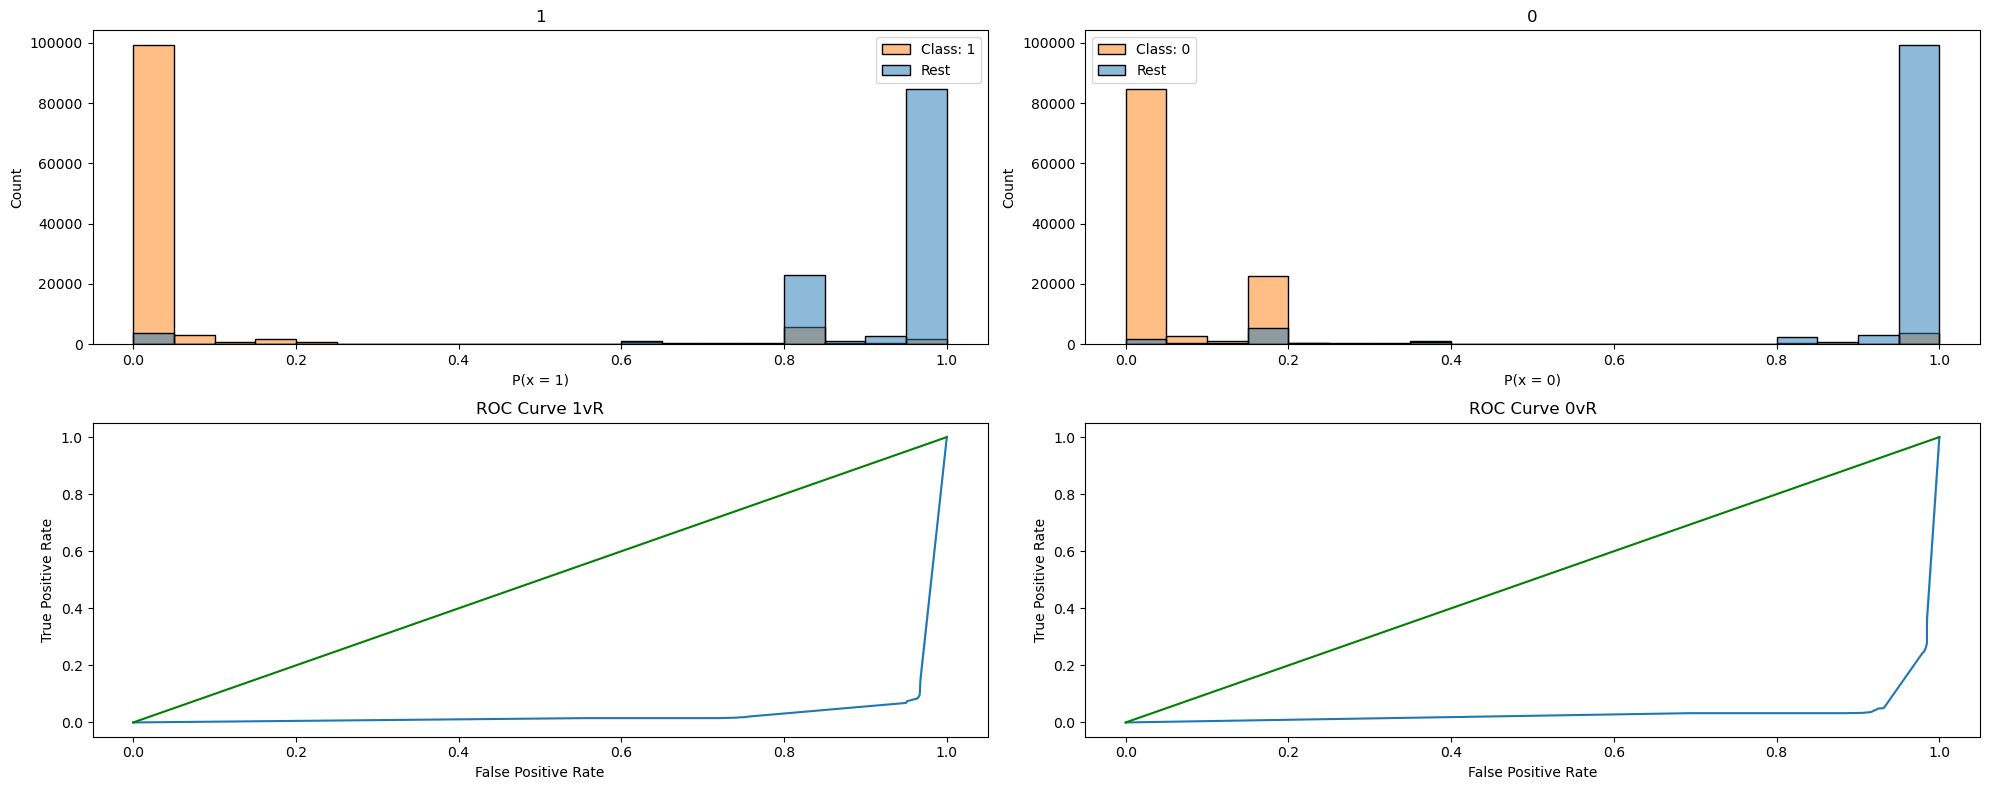

1 vs 0 ROC AUC OvO: 0.0399
0 vs 1 ROC AUC OvO: 0.0395
average ROC AUC OvO: 0.0397


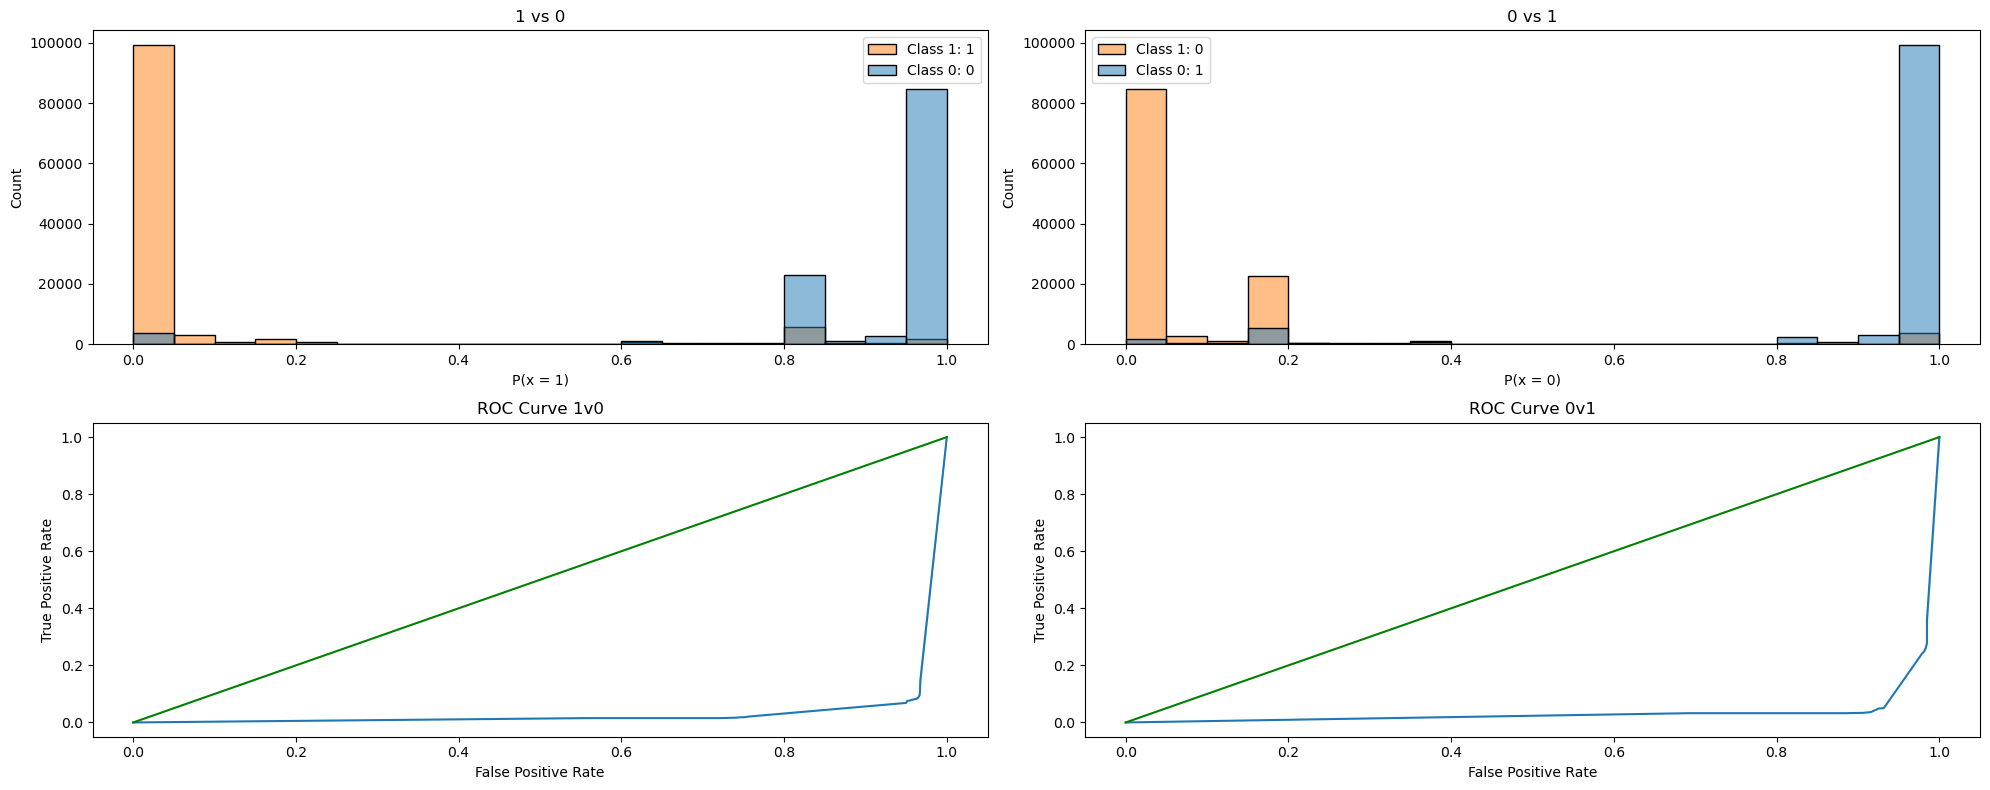

true
0    117485
1    115300
Name: count, dtype: int64

In [16]:
df_pred = model.predict(df_test,x_columns=col_x,y_column=col_y)
roc = CSHROC(df_pred)
roc.show_ROC_by_one_rest(prob_bins=100)
roc.show_ROC_by_one_one(prob_bins=100)
df_pred['true'].value_counts()